In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
import functools
import collections
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import random

#generate random id
import uuid

#ICC in python
import pingouin as pg

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from xgboost import plot_importance
#plot
import matplotlib.pyplot as plt
import seaborn as sns

#neural net
#Initializing the MLPClassifier
#the length of tuple denotes the total number of hidden layers in the network.
#hidden_layer_sizes : This parameter allows us to set the number of layers and the number of nodes we wish to have in the Neural Network Classifier.
#max_iter: It denotes the number of epochs.
#activation: The activation function for the hidden layers.
#solver: This parameter specifies the algorithm for weight optimization across the nodes.
#random_state: The parameter allows to set a seed for reproducing the same results   
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
#Fitting the training data to the network
classifier.fit(X_train, Y_train)
#Predicting y for X_val
y_pred = classifier.predict(X_val)

In [ ]:
#proba next to it!!!!!!!!!!!!"very good"
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)
KNeighborsClassifier(...)
print(neigh.predict([[1.1]]))
print(neigh.predict_proba([[0.9]]))

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_WG_open, ConfMat, list_of_zones, res_intodico, all_subsets
import config_origins as config

C:\Users\camil\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Download Input Data

In [3]:
#define parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
dico_garden_opening_hour = config.dico_garden_opening_hour
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
#path_extracted_data_cleaning = r'D:\vm_exchange\PhD_Data\LogsCleaning'
#create a director if not existing
if not os.path.exists(path_extracted_data_cleaning):
    os.makedirs(path_extracted_data_cleaning)
    
path__ = os.path.join(path_extracted_data_cleaning,'1secTS')
#create a director if not existing
if not os.path.exists(path__):
    os.makedirs(path__)

In [4]:
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'InputCleaning.csv'), parse_dates=['Timestamp', 'date'], 
                 dayfirst=True, sep=';')
df = shuffle(df)
df = df.rename(columns={c:c.replace('_','') for c in df.columns})
df['HenID'] = df['HenID'].map(lambda x: 'hen_'+str(int(x)))
print(df.shape)
df.head(3)

(3546, 36)


,Timestamp,TagID,HenID,Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previousZone==NextZone,nextduration,BatchID,zone2match,zone3match,zone4match,ObservedZone,zone3matchexist,next2zone==Zone,previous2zone==Zone
1249,2020-10-16 15:02:51,117,hen_177,3_Zone,10.0,0,10 - 12,2020-10-16,students,5.0,...,True,3.0,NaN,miniZone3,NoOtherZone,NoOtherZone,2_Zone,False,True,False
2061,2020-10-17 14:29:25,2,hen_40,3_Zone,3.0,1,3 - 5,2020-10-17,students,11.0,...,True,190.0,NaN,miniZone3,NoOtherZone,NoOtherZone,3_Zone,False,True,True
415,2020-10-19 11:33:06,59,hen_11,3_Zone,5.0,0,3 - 5,2020-10-19,students,11.0,...,True,83.0,NaN,5_Zone,4_Zone,2_Zone,5_Zone,True,True,True


In [5]:
df['PenID'].value_counts()

5.0     868
10.0    652
8.0     603
3.0     517
9.0     373
12.0    224
4.0     216
11.0     93
Name: PenID, dtype: int64

In [6]:
df['VideoAnalyse'].value_counts()

1    2785
0     761
Name: VideoAnalyse, dtype: int64

# Split into training-validation and testing (holdout dataset)

In [7]:
df['zone3match'].value_counts()

NoOtherZone    1019
2_Zone          794
4_Zone          758
5_Zone          619
miniZone3       198
3_Zone          132
1_Zone           26
Name: zone3match, dtype: int64

In [8]:
#available features (zone4match is totally point less it ~never exist)
licat = ['TagID', 'Zone', 'PenID', 'VideoAnalyse', 'system', 'date',
         'zone2match', 'zone3match','zone3matchexist',
         'next1zone','next2zone', 'next3zone', 'next4zone', 'next5zone',
         'previous1zone', 'previous2zone', 'previous3zone', 'previous4zone','previous5zone']
licont = ['signalstrength', 'signalstzone2', 'signalstrzone3', 'signalstrzone4', 'duration','previousduration','nextduration',
         'next2zone==Zone','previous2zone==Zone','previousZone==NextZone']

#select some features
li_cont_select = ['signalstrength', 'signalstzone2','duration','nextduration','previousduration',
                 'next2zone==Zone','previous2zone==Zone','zone3matchexist'] 
li_cat_select = ['Zone','zone2match','previous1zone','next1zone'] #ADD WHEN WE HAVE DORIS DATA: PenID
#zone3match_exist: important for WG cleaning

In [9]:
#necessary to sum categories within the features importances
for x in li_cat_select+['ObservedZone']:
    df[x] = df[x].map(lambda x: str(x).replace('_',''))
df[li_cont_select+li_cat_select].head(3)

,signalstrength,signalstzone2,duration,nextduration,previousduration,next2zone==Zone,previous2zone==Zone,Zone,zone2match,zone3matchexist,previous1zone,next1zone
1249,5.0,3.0,35.0,3.0,43.0,True,False,3Zone,miniZone3,False,2Zone,2Zone
2061,11.0,10.0,86.0,190.0,37.0,True,True,3Zone,miniZone3,False,3Zone,3Zone
415,11.0,10.0,99.0,83.0,65.0,True,True,3Zone,5Zone,True,5Zone,5Zone


In [10]:
#show rows with at least one nan
df[df.isna().any(axis=1)]

,Timestamp,TagID,HenID,Zone,PenID,VideoAnalyse,system,date,type,signalstrength,...,previousZone==NextZone,nextduration,BatchID,zone2match,zone3match,zone4match,ObservedZone,zone3matchexist,next2zone==Zone,previous2zone==Zone
1249,2020-10-16 15:02:51,117,hen_177,3Zone,10.0,0,10 - 12,2020-10-16,students,5.0,...,True,3.0,NaN,miniZone3,NoOtherZone,NoOtherZone,2Zone,False,True,False
2061,2020-10-17 14:29:25,2,hen_40,3Zone,3.0,1,3 - 5,2020-10-17,students,11.0,...,True,190.0,NaN,miniZone3,NoOtherZone,NoOtherZone,3Zone,False,True,True
415,2020-10-19 11:33:06,59,hen_11,3Zone,5.0,0,3 - 5,2020-10-19,students,11.0,...,True,83.0,NaN,5Zone,4_Zone,2_Zone,5Zone,True,True,True
1000,2020-10-14 13:33:15,16,hen_92,2Zone,3.0,1,3 - 5,2020-10-14,students,3.0,...,True,18.0,NaN,miniZone3,NoOtherZone,NoOtherZone,2Zone,False,False,True
1401,2020-10-17 13:51:16,117,hen_177,3Zone,10.0,1,10 - 12,2020-10-17,students,10.0,...,False,1046.0,NaN,miniZone3,2_Zone,NoOtherZone,3Zone,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887,2020-10-25 16:02:49,49,hen_122,2Zone,12.0,1,10 - 12,2020-10-25,students,3.0,...,False,7.0,NaN,NoOtherZone,NoOtherZone,NoOtherZone,2Zone,False,False,True
2325,2020-10-18 14:11:57,130,hen_49,2Zone,10.0,1,10 - 12,2020-10-18,students,9.0,...,False,6.0,NaN,NoOtherZone,NoOtherZone,NoOtherZone,2Zone,False,True,True
472,2020-10-19 14:07:25,3,hen_104,3Zone,3.0,1,3 - 5,2020-10-19,students,12.0,...,False,4.0,NaN,miniZone3,NoOtherZone,NoOtherZone,3Zone,False,False,True
2862,2020-10-25 14:58:20,49,hen_122,2Zone,12.0,1,10 - 12,2020-10-25,students,15.0,...,False,58.0,NaN,1Zone,NoOtherZone,NoOtherZone,2Zone,False,False,True


In [11]:
#exception
print(df.shape)
df = df[~((df['nextduration'].isnull())&(df['algotype']=='cleaning'))]
print(df.shape)

(3546, 36)
(3546, 36)


In [12]:
df_testing = df[df['algotype']=='verification'].copy()
df_cleaning = df[df['algotype']=='cleaning'].copy()

In [13]:
df_cleaning['VideoAnalyse'].value_counts()

1    2516
0     748
Name: VideoAnalyse, dtype: int64

In [14]:
print(df_testing.shape, df_cleaning.shape)

(282, 36) (3264, 36)


# Split into training and validation (for parameter tuning)

In [15]:
#transform categorical data into dumies
df_cl_d = pd.get_dummies(df_cleaning.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
df_te_d = pd.get_dummies(df_testing.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)

if len(df_te_d.columns)!=len(df_cl_d.columns):
    print('the test set does not have the same amount of features than the cleaning set, certainly due to low amount of data,\
    Please remove some varibles that has missing values in the testing set')
    sys.exit()
    
#train
X_train = df_cl_d.values
y_train = df_cleaning[['VideoAnalyse']].values
print(X_train.shape, y_train.shape)

#test
X_test = df_te_d.values
y_test = df_testing[['VideoAnalyse']].values
print(X_test.shape, y_test.shape)

#var name
var_name = df_cl_d.columns

#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test) 

#split training into validation
state = 10  
val_size = 0.25  
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=state)

(3264, 26) (3264, 1)
(282, 26) (282, 1)


In [16]:
#show rows with at least one nan
display(df_cl_d[df_cl_d.isna().any(axis=1)])
df_te_d[df_te_d.isna().any(axis=1)]

,signalstrength,signalstzone2,duration,nextduration,previousduration,next2zone==Zone,previous2zone==Zone,Zone_2Zone,Zone_3Zone,Zone_4Zone,...,zone2match_miniZone3,zone3matchexist_True,previous1zone_2Zone,previous1zone_3Zone,previous1zone_4Zone,previous1zone_5Zone,next1zone_2Zone,next1zone_3Zone,next1zone_4Zone,next1zone_5Zone


,signalstrength,signalstzone2,duration,nextduration,previousduration,next2zone==Zone,previous2zone==Zone,Zone_2Zone,Zone_3Zone,Zone_4Zone,...,zone2match_miniZone3,zone3matchexist_True,previous1zone_2Zone,previous1zone_3Zone,previous1zone_4Zone,previous1zone_5Zone,next1zone_2Zone,next1zone_3Zone,next1zone_4Zone,next1zone_5Zone


# Model

C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

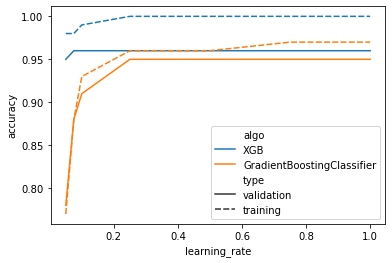

In [17]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
li_dico = []
for lr in lr_list:
    dico_mod = {#'GaussianProcessClassifier': GaussianProcessClassifier(1.0 * RBF(1.0), learning_rate=lr), 
                #'RandomForest':RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, learning_rate=lr),
                 #'RBF SVM':SVC(gamma=2, C=1, learning_rate=lr),
                 #'neural net':MLPClassifier(alpha=1, max_iter=1000, learning_rate=lr),
                 #'naive bayes':GaussianNB(learning_rate=lr),
                 'XGB': XGBClassifier(learning_rate=lr),
                 'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=20, learning_rate=lr, max_features=2, 
                                        max_depth=2, random_state=0)}
    for name,mod in dico_mod.items():
        mod.fit(X_train, y_train)
        li_dico.append({'algo':name, 'learning_rate':lr, 'type':'validation','accuracy':round(mod.score(X_val, y_val),2)})
        li_dico.append({'algo':name, 'learning_rate':lr, 'type':'training', 'accuracy':round(mod.score(X_train, y_train),2)})

#Alternatively, you could predict the X_val data and then check the accuracy against the y_val by using accuracy_score. 
#It should give you the same kind of result.
df_result = pd.DataFrame(li_dico)
sns.lineplot(data=df_result, x="learning_rate", y="accuracy", hue="algo", style="type");
#plt.savefig(os.path.join(path_extracted_data_cleaning,id_run+'_ClassifierParamTuningLearningRate.png'), bbox_inches='tight')

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


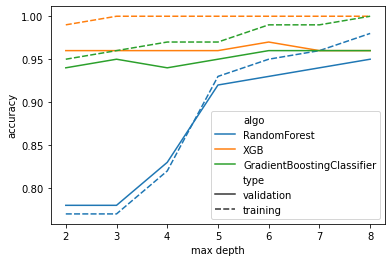

In [34]:
li_dico = []
for md in [2,3,4,5,6,7,8]:
    dico_mod = {#'GaussianProcessClassifier': GaussianProcessClassifier(1.0 * RBF(1.0), max_depth=md), 
                'RandomForest':RandomForestClassifier(n_estimators=10, max_features=1, max_depth=md),
                #'RBF SVM':SVC(gamma=2, C=1, max_depth=md),
                #'neural net':MLPClassifier(alpha=1, max_iter=1000, max_depth=md),
                #'naive bayes':GaussianNB(max_depth=md),
                'XGB': XGBClassifier(learning_rate=0.5, max_depth=md),
                'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=20, learning_rate=0.15, max_features=2, 
                                        max_depth=md, random_state=0),
                #'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=4, weights='uniform')}
    for name,mod in dico_mod.items():
        mod.fit(X_train, y_train)
        li_dico.append({'algo':name, 'max depth':md, 'type':'validation','accuracy':round(mod.score(X_val, y_val),2)})
        li_dico.append({'algo':name, 'max depth':md, 'type':'training', 'accuracy':round(mod.score(X_train, y_train),2)})

#Alternatively, you could predict the X_val data and then check the accuracy against the y_val by using accuracy_score. 
#It should give you the same kind of result.
df_result = pd.DataFrame(li_dico)
sns.lineplot(data=df_result, x="max depth", y="accuracy", hue="algo", style="type");
#plt.savefig(os.path.join(path_extracted_data_cleaning,id_run+'_ClassifierParamTuningMaxdepth.png'), bbox_inches='tight')

### fit best model

In [19]:
#https://www.kaggle.com/ericbae731/feature-importance-of-gradient-boosting-simple

In [20]:
model = XGBClassifier(learning_rate=0.5, max_depth=3)
model.fit(X_train, y_train)

C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(learning_rate=0.5)

TODO
#choose parameters!!
GradientBoostingClassifier(loss=’deviance’, learning_rate=0.1, n_estimators=100, 
                            subsample=1.0, criterion=’friedman_mse’, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, 
                            min_impurity_decrease=0.0, min_impurity_split=None, init=None, 
                            random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, 
                            warm_start=False, presort=’auto’, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=0)
clf.fit(tr_x, tr_y)

# Feature importance

#plot feature importance: Fscore!
plot_importance(model)
plt.show()

#old
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance = model.feature_importances_
#make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
plt.figure(figsize=(3, 7))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, var_name[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

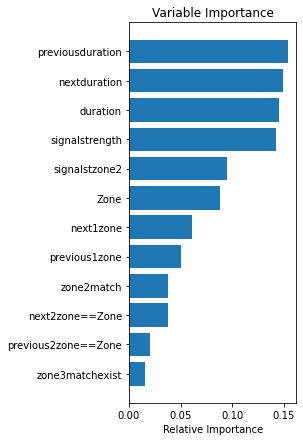

In [21]:
feature_importance = model.feature_importances_
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())
dico_f_imp = {var_name[i]:feature_importance[i] for i in range(0,len(var_name))}
#display(dico_f_imp)
dico_fg_imp = {x.split('_')[0]:sum([dico_f_imp[i] for i in dico_f_imp.keys() if i.split('_')[0]==x.split('_')[0]]) for x in dico_f_imp.keys()}
#display(dico_fg_imp)
#sort the dictionary by the importance values
dico_fg_imp_sorted = {k: v for k, v in sorted(dico_fg_imp.items(), key=lambda item: item[1])}
plt.figure(figsize=(3, 7))
pos = [i+0.5 for i in range(0,len(dico_fg_imp))]
plt.barh(pos, dico_fg_imp_sorted.values(), align='center')
plt.yticks(pos, dico_fg_imp_sorted.keys())
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig(os.path.join(path_extracted_data_cleaning,'FeaturesImportance.png'), bbox_inches='tight')
plt.show()

### Relevance of algorithm on validation data

C:\Users\camil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


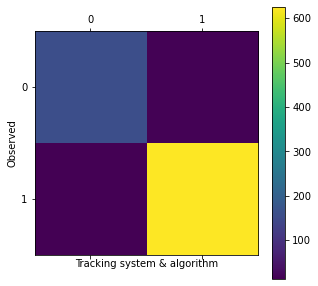

In [22]:
ConfMat(li_true=y_val, 
        li_pred=model.predict(X_val), 
        labels=[0,1], 
        path_save=os.path.join(path_extracted_data_cleaning,id_run+'_CM_model_validating.png'), 
        xlabel_='Tracking system & algorithm')

# Relevance on TESTING DATA

In [23]:
#TO ADD NEW BATCHES WHEN WE HAVE NEW ONES
dico_BatchID_endhour = {'ID1':16,
                        'ID2':16,
                        'ID3':16,
                        'ID5':13,
                        'ID8':12,
                        'ID9':12,
                        'ID10':16,
                        'ID11':12,
                        'ID12':16,
                        'ID13':13,
                        'ID14':16,
                        'ID17':12}

In [24]:
##########################################################################################################
################################################ predict #################################################
##########################################################################################################
#transform categorical data into dumies
df_te_d = pd.get_dummies(df_testing.filter(li_cont_select+li_cat_select, axis=1), columns=li_cat_select, drop_first=True)
X_test = df_te_d.values
#y_test = df_testing[['VideoAnalyse']].values
predictions = model.predict(X_test)
df_testing['model_prediction'] = predictions
df_testing.groupby(['Zone','model_prediction'])['date'].count().reset_index()
#add the zone that would be selected with this algorithm output: if==0, then the true zone is the one before
df_testing['model_prediction'] = df_testing['model_prediction'].astype(str)
df_testing['model_ObservedZone'] = df_testing.apply(lambda x: x['Zone'] if x['model_prediction']=='1' else x['previous1zone'],
                                                    axis=1)
df_testing['tracking_prediction'] = 1
#save
df_testing.to_csv(os.path.join(path_extracted_data_cleaning, id_run+'_TestingMethods.csv'), 
                      index=False, sep=';')
#display(df_testing.head(3))

In [35]:
model.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [36]:
model.predict_proba(X_test)

array([[9.16361809e-04, 9.99083638e-01],
       [5.21719456e-04, 9.99478281e-01],
       [4.05848026e-04, 9.99594152e-01],
       [1.62494183e-03, 9.98375058e-01],
       [3.18288803e-05, 9.99968171e-01],
       [3.51667404e-05, 9.99964833e-01],
       [1.42455101e-04, 9.99857545e-01],
       [1.85191631e-04, 9.99814808e-01],
       [2.19267607e-03, 9.97807324e-01],
       [2.99215317e-05, 9.99970078e-01],
       [8.05795193e-04, 9.99194205e-01],
       [9.05746818e-02, 9.09425318e-01],
       [8.34465027e-06, 9.99991655e-01],
       [5.09977341e-04, 9.99490023e-01],
       [2.17543840e-02, 9.78245616e-01],
       [2.55048275e-04, 9.99744952e-01],
       [5.35756350e-02, 9.46424365e-01],
       [7.42932916e-01, 2.57067084e-01],
       [8.07087600e-01, 1.92912400e-01],
       [2.60531902e-04, 9.99739468e-01],
       [1.77985430e-03, 9.98220146e-01],
       [9.46557522e-03, 9.90534425e-01],
       [6.46966696e-03, 9.93530333e-01],
       [3.67045403e-04, 9.99632955e-01],
       [3.087520

In [ ]:
predict_proba

In [25]:
df_testing['VideoAnalyse'].value_counts()

1    269
0     13
Name: VideoAnalyse, dtype: int64

In [26]:
##########################################################################################################
################################# select pairs' combinations of batches ##################################
##########################################################################################################

#number of combination's pair to run for each size
nbr_comb = 4
#minimum nbr of batches to have in a run
min_nbr_batch = 6 #5 is the minimum for transition reliability

#compute all possible batch combinations of any size
li_batch = df_testing['BatchID'].unique()
li_batch_combination = list(all_subsets(li_batch))

#list of distinct pairs of batch combinations of different size
li_selected_combination_pairs = []
#to have distinct pairs, we cant do more than half of what we have
for nbr_batch in tqdm.tqdm(range(min_nbr_batch, int(len(li_batch)/2))):
    li_sel = []
    li = [x for x in li_batch_combination if len(x)==nbr_batch]
    while len(li_sel)!=nbr_comb:
        li = shuffle(li)
        x1 = li[0]
        for l in li:
            if 2*len(l)==len(set(l+x1)):
                li_sel.append([x1,l])
                #ensure we dont use the sme twice
                li.remove(l) ; li.remove(x1)
                break
    li_selected_combination_pairs.extend(li_sel)
#do the one with all batches for final outputs
li_selected_combination_pairs.append([tuple(li_batch),tuple(li_batch)])
li_selected_combination_pairs[0:3]

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 41.57it/s]


[[('ID14', 'ID1', 'ID5', 'ID8', 'ID17', 'ID10'),
  ('ID2', 'ID7', 'ID9', 'ID11', 'ID16', 'ID6')],
 [('ID9', 'ID11', 'ID1', 'ID12', 'ID3', 'ID16'),
  ('ID14', 'ID2', 'ID4', 'ID5', 'ID10', 'ID6')],
 [('ID14', 'ID15', 'ID1', 'ID12', 'ID4', 'ID13'),
  ('ID7', 'ID3', 'ID5', 'ID8', 'ID17', 'ID6')]]

In [28]:
###############################################################################################################################
###############################################################################################################################
############################################# RUN OVER SEVERAL BATCH COMBINATIONS #############################################
###############################################################################################################################
###############################################################################################################################

#start recording the time it last
START_TIME = time.clock()
li_df  = []
is_done = False
for li_batch1, li_batch2 in tqdm.tqdm(li_selected_combination_pairs):
    
    #select a unique runID per pair of batch combination
    runID = uuid.uuid1()
    nbr_b = len(li_batch1)
    
    for i,li_batch in enumerate([li_batch1, li_batch2]):
        #dont do the second batch if its the same as the first one, i.e. if its the final output, but print visuals
        if (li_batch1==li_batch2) & (is_done==True):
            #to sort the yaxis
            dico_zone_order = {'1Zone':0,
                               '2Zone':1,
                               '3Zone':2,
                               '4Zone':3,
                               '5Zone':4}

            #create path where to save if not existing yet
            path_ = os.path.join(path_extracted_data_cleaning,'TimeSeriesPlot')
            #create a director if not existing
            if not os.path.exists(path_):
                os.makedirs(path_) 

            li_ts = ['Zone','model_ObservedZone','ObservedZone','binning_zone']
            #for each batch draw 4 timeseries
            for BatchID, df_plt in tqdm.tqdm(df_final.groupby(['BatchID'])):
                df_plt = df_plt.sort_values(['Timestamp']).copy()
                l = len(li_ts) ; c = 1
                fig = plt.figure(figsize=(c*5, l*1))
                for i,v in enumerate(li_ts):
                    df_plt[v] = df_plt[v].map(lambda x: int(dico_zone_order[x]))       
                    plt.subplot(l,c,i+1)
                    plt.plot(df_plt['Timestamp'].tolist(), df_plt[v].tolist())
                    plt.xticks(fontsize=4)
                    plt.yticks(fontsize=4)
                    plt.title(v+' '+BatchID, size=7)
                plt.savefig(os.path.join(path_extracted_data_cleaning, BatchID+'.png'), format='png', bbox_inches='tight', dpi=300)
                plt.clf()
                plt.close("all")                      
            
            break
            
        df_testing_ = df_testing[df_testing['BatchID'].isin(li_batch)].copy()
        ##########################################################################################################
        ########################################### create duration TS ###########################################
        ##########################################################################################################
        li_df_dur = []
        li_col = ['Zone','VideoAnalyse','model_ObservedZone','ObservedZone','PenID','HenID','Timestamp','BatchID']
        for BatchID,df_ in df_testing_[li_col].groupby(['BatchID']):
            df_ = df_.sort_values('Timestamp',ascending=True)
            #select the list of timestamp we want (i.e. at one second level)
            mi = min(df_['Timestamp'].tolist())
            ma = max(df_['Timestamp'].tolist())
            #extend the daterange if the batch is in dico_BatchID_endhour
            if BatchID in dico_BatchID_endhour.keys():
                ma = dt.datetime(ma.year,ma.month,ma.day,dico_BatchID_endhour[BatchID],0,0)
            #print(mi, ma)
            Daterange = pd.date_range(start = mi+dt.timedelta(seconds=(60-mi.second)), 
                                      end = ma-dt.timedelta(seconds=(ma.second+1)), 
                                      freq = 'S') 
            #print(Daterange[0:2])
            #print(Daterange[-2:])

            ################### 1 sec ts: tracking method & model method & true observation
            ### extend to 1 seconds level
            #add missing seconds (i.e. all seconds that never had a record) and fillnan with last non-nan values by propagating last 
            # observation forward to next valHenIDmi = min(df_['Timestamp'].tolist())
            df_.set_index('Timestamp', inplace=True)
            df__ = df_.reindex(Daterange, method='ffill').reset_index()
            #display(df__.head(5))
            #display(df__.tail(5))
            df__.rename(columns={'index':'Timestamp'}, inplace=True)
            #display(df__.head(3))
            df__.to_csv(os.path.join(path__,'1secTimeSeries'+str(BatchID)+'.csv'), sep=';', index=False)

            ################### binning method at 60 sec period
            #First take only the wanted timestamps (1 per seconds)
            #due to the 60 sec period bining, we need to exclude some of the first and last seconds in order to take into account 
            #minutes for which we have the full information only
            DaterangeBIN = [Daterange[i] for i in range(len(Daterange)) if i%60==0]
            #add new timestamp to the initial file
            df_date = pd.DataFrame({'New_Timestamp':DaterangeBIN})
            df_date['New_Timestamp'] = df_date['New_Timestamp'].map(lambda x: pd.to_datetime(x))
            df_bin = pd.merge_asof(df__, df_date, left_on=['Timestamp'], right_on=['New_Timestamp'], direction='forward')

            #Then bin the data
            h = 'Zone'
            df_bin = df_bin[[h,'New_Timestamp']].copy()
            df_bin['nbr_sec'] = 1
            df_bin = df_bin.groupby(['New_Timestamp',h])['nbr_sec'].sum().reset_index() #sum to count as we have seconds
            df_bin = df_bin.groupby(['New_Timestamp'])[h,'nbr_sec'].agg(lambda x: tuple(x)).reset_index()
            df_bin['most_frequent_zone'] = df_bin.apply(lambda x: x[h][x['nbr_sec'].index(max(x['nbr_sec']))], axis=1)
            df_bin['nbr_duration_per_zone'] = df_bin.apply(lambda x: str({x[h][k]:x['nbr_sec'][k] for k in range(len(x[h]))}), axis=1)
            df_bin['nbr_lost_duration_per_zone'] = df_bin['nbr_duration_per_zone'].map(lambda x: str({z:v for z,v in eval(x).items() if \
                                                                               v!=max(eval(x).values())}))
            df_bin['nbr_lost_duration'] = df_bin['nbr_lost_duration_per_zone'].map(lambda x: sum(eval(x).values()))
            df_bin['perc_lost_duration'] = df_bin['nbr_lost_duration'].map(lambda x: x/60*100)
            df_bin['day'] = df_bin['New_Timestamp'].map(lambda x: dt.datetime(x.year,x.month,x.day))
            df_bin.to_csv(os.path.join(path__ ,'bining'+str(BatchID)+'.csv'), sep=';', index=False)
            #display(df_bin.head(3))    

            #extend to 1sec ts
            df_bin = df_bin[['most_frequent_zone','New_Timestamp']]
            df_bin.set_index('New_Timestamp', inplace=True)
            df_bin1sec = df_bin.reindex(Daterange, method='ffill').reset_index()
            df_bin1sec.rename(columns={'index':'Timestamp','most_frequent_zone':'binning_zone'}, inplace=True)
            df_bin1sec.to_csv(os.path.join(path__,'1secTimeSeries_bining'+str(BatchID)+'.csv'), sep=';', index=False)
            #display(df_bin1sec.head(3))

            #join with bining
            df_final = pd.merge(df__, df_bin1sec, on=['Timestamp'], how='outer')
            df_final.to_csv(os.path.join(path__,'1secTimeSeries_ALL_'+str(BatchID)+'.csv'), sep=';', index=False)
            li_df_dur.append(df_final)
        #concat all final 1sec into one big
        df_final = pd.concat(li_df_dur)
        df_final.to_csv(os.path.join(path_extracted_data_cleaning,'1secTimeSeries_reliability.csv'), sep=';', index=False)
        #display(df_final.head(3))

        ##########################################################################################################
        ########################################### create duration TS ###########################################
        ##########################################################################################################
        #in case: total nbr of zone, issue: not enough observatoin for kappa test 
        #df_transition = df_final.groupby(['BatchID'])[['Zone','model_ObservedZone','ObservedZone',
        #                                               'binning_zone']].agg(lambda x: len(list_of_zones(x))-1).reset_index()
                
        li_df_zone = []
        for c in ['Zone','model_ObservedZone','ObservedZone','binning_zone']:
            df_transition_ = df_final.groupby(['BatchID'])[c].agg(lambda x: dict(Counter(list_of_zones(x)[1:]))).reset_index()
            for z in df_final[c].unique():
                df_transition_[z] = df_transition_[c].map(lambda x: x.get(z,0))
            df_ = pd.melt(df_transition_, id_vars=['BatchID'], value_vars=df_final[c].unique())
            df_.rename(columns={'value':c}, inplace=True)
            li_df_zone.append(df_)
        df_transition = li_df_zone[0]
        for df_ in li_df_zone[1:]:
            df_transition = pd.merge(df_, df_transition, on=['BatchID','variable'], how='outer')
        print(df_transition.shape)
        df_transition.head(3)
        #display(df_transition.head(3))
        df_transition.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_transition.csv'), sep=';', index=False)
        
        print(df_testing_.shape, df_final.shape, df_transition.shape)
        ##########################################################################################################
        ###################################### relevance algo - records 0-1 ######################################
        ##########################################################################################################
        dico_name = {'tracking_prediction':'Zone','model_prediction':'model_ObservedZone'}
        #tracking_prediction
        for c in ['model_prediction']:
            li_t = df_testing_['VideoAnalyse'].astype(int).tolist()
            li_p = df_testing_[c].astype(int).tolist()
            res = classification_report(li_t, li_p, output_dict=True)
            dico_ = res_intodico(res)
            dico_['method'] = dico_name[c]
            dico_['reliability_type'] = 'records-01'
            dico_['kappa'] = cohen_kappa_score(li_t, li_p)
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)

        ##########################################################################################################
        ###################################### relevance algo - records zone #####################################
        ##########################################################################################################
        for c in ['Zone','model_ObservedZone']:
            li_t = df_testing_['ObservedZone'].tolist()
            li_p = df_testing_[c].tolist()            
            res = classification_report(li_t, li_p, output_dict=True)
            dico_ = res_intodico(res)
            dico_['method'] = c
            dico_['reliability_type'] = 'records-zone'
            dico_['kappa'] = cohen_kappa_score(li_t, li_p)
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)

        ##########################################################################################################
        ############################### relevance behavioural data - duration 1secTS #############################
        ##########################################################################################################
        for c in ['Zone','model_ObservedZone','binning_zone']:
            li_t = df_final['ObservedZone'].tolist()
            li_p = df_final[c].tolist()
            res = classification_report(li_t, li_p, output_dict=True)
            dico_ = res_intodico(res)
            dico_['method'] = c
            dico_['reliability_type'] = 'duration_1secTS'
            dico_['kappa'] = cohen_kappa_score(li_t, li_p)
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)

        ##########################################################################################################
        ################################## relevance behavioural data - transition ###############################
        ##########################################################################################################
        #does not make sense to compare per minutes the numebr of transition, as we dont really care if they areshifted by few minutes
        #instead we will compare the number of transition per batch 
        for c in ['Zone', 'model_ObservedZone', 'binning_zone']:
            df_ = pd.melt(df_transition.filter(['BatchID','ObservedZone', c],axis=1), id_vars=['BatchID'], 
                          value_vars=['ObservedZone', c])
            #continuous reliability score
            df_res = pg.intraclass_corr(data=df_, targets='BatchID', raters='variable', ratings='value')
            dico_ = df_res[df_res['Type']=='ICC3'].to_dict(orient='records')[0]
            dico_['method'] = c
            dico_['reliability_type'] = 'transitions'
            dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
            li_df.append(dico_)
        #per zone for all the batches only
        if li_batch1==li_batch2:
            is_done=True
            for z,df__ in df_transition.groupby('variable'):
                for c in ['Zone', 'model_ObservedZone', 'binning_zone']:
                    df_ = pd.melt(df__.filter(['BatchID','ObservedZone', c],axis=1), id_vars=['BatchID'], 
                                  value_vars=['ObservedZone', c])
                    #continuous reliability score
                    df_res = pg.intraclass_corr(data=df_, targets='BatchID', raters='variable', ratings='value')
                    dico_ = df_res[df_res['Type']=='ICC3'].to_dict(orient='records')[0]
                    dico_['method'] = c
                    dico_['reliability_type'] = 'transitions_'+z
                    dico_['runID'] = runID; dico_['li_batch_selected'] = li_batch; dico_['nbr_batch'] = nbr_b ; dico_['CPairID'] = i
                    li_df.append(dico_)            
            

##########################################################################################################
############################################### Save results #############################################
##########################################################################################################
END_TIME = time.clock()
print ("Total running time: %.2f mn" %((END_TIME-START_TIME)/60))
df_results = pd.DataFrame(li_df)
li_var_tr = ['transitions','transitions_1Zone', 'transitions_2Zone', 'transitions_3Zone','transitions_4Zone', 
             'transitions_5Zone']
df_results['accuracy_ICC'] = df_results.apply(lambda x: x['ICC'] if x['reliability_type'] in li_var_tr else x['accuracy'], 
                                              axis=1)
#df_results.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTS.csv'), sep=';', index=False)
df_results[['accuracy','ICC','kappa','runID','method','reliability_type']]

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(83, 39) (34200, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(98, 39) (36000, 9) (30, 6)


 11%|█████████▎                                                                          | 1/9 [00:38<05:10, 38.82s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(114, 39) (39960, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(103, 39) (31620, 9) (30, 6)


 22%|██████████████████▋                                                                 | 2/9 [01:18<04:33, 39.03s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(24, 6)
(143, 39) (36900, 9) (24, 6)


C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(49, 39) (28680, 9) (30, 6)


 33%|████████████████████████████                                                        | 3/9 [01:56<03:52, 38.76s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(107, 39) (33360, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(30, 6)
(82, 39) (33600, 9) (30, 6)


C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
 44%|█████████████████████████████████████▎                                              | 4/9 [02:33<03:11, 38.28s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(114, 39) (41400, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(113, 39) (37380, 9) (35, 6)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:19<02:42, 40.51s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(118, 39) (46080, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(140, 39) (39420, 9) (35, 6)


 67%|████████████████████████████████████████████████████████                            | 6/9 [04:05<02:06, 42.09s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(116, 39) (43200, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(114, 39) (34980, 9) (35, 6)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [04:49<01:25, 42.78s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(95, 39) (37920, 9) (35, 6)


C:\Users\camil\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(35, 6)
(122, 39) (46560, 9) (35, 6)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [05:43<00:46, 46.28s/it]C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


(85, 6)
(282, 39) (98640, 9) (85, 6)


C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror
C:\Users\camil\Anaconda3\lib\site-packages\pingouin\parametric.py:978: RuntimeWarning: divide by zero encountered in double_scalars
  fval = msbetween / mserror

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:13<00:00, 48.21s/it]

Total running time: 7.23 mn


,accuracy,ICC,kappa,runID,method,reliability_type
0,0.963855,NaN,0.647808,84636466-30c7-11eb-bd1e-9822ef705bb4,model_ObservedZone,records-01
1,0.951807,NaN,0.919768,84636466-30c7-11eb-bd1e-9822ef705bb4,Zone,records-zone
2,0.963855,NaN,0.940402,84636466-30c7-11eb-bd1e-9822ef705bb4,model_ObservedZone,records-zone
3,0.998655,NaN,0.997787,84636466-30c7-11eb-bd1e-9822ef705bb4,Zone,duration_1secTS
4,0.990556,NaN,0.984319,84636466-30c7-11eb-bd1e-9822ef705bb4,model_ObservedZone,duration_1secTS
...,...,...,...,...,...,...
163,NaN,0.989924,NaN,5165c42e-30c8-11eb-8467-9822ef705bb4,model_ObservedZone,transitions_4Zone
164,NaN,0.885057,NaN,5165c42e-30c8-11eb-8467-9822ef705bb4,binning_zone,transitions_4Zone
165,NaN,0.968127,NaN,5165c42e-30c8-11eb-8467-9822ef705bb4,Zone,transitions_5Zone
166,NaN,0.968127,NaN,5165c42e-30c8-11eb-8467-9822ef705bb4,model_ObservedZone,transitions_5Zone


In [32]:
df_results['nbr_batch'].value_counts()

7     72
6     72
17    24
Name: nbr_batch, dtype: int64

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


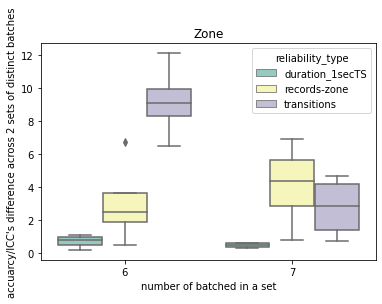

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


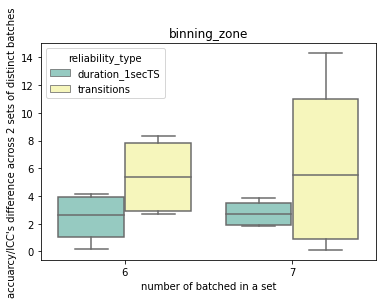

C:\Users\camil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


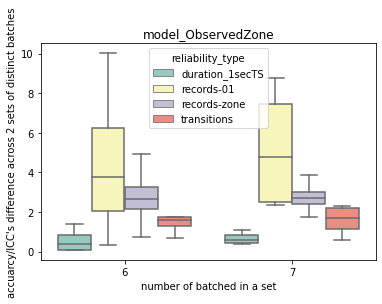

(72, 6)
LOOk AT THIS AND VERIFY THE OUTPUT


,runID,reliability_type,nbr_batch,accuracy_ICC,li_batch_selected,accuracy_ICC_diff


,ICC,F,df1,df2,pval,CI95%
162,1.0,-6.738842e+15,16.0,16.0,1.0,"[1.0, 1.0]"
167,1.0,-7.351464e+15,16.0,16.0,1.0,"[1.0, 1.0]"


In [30]:
#visualize the results
li_df = []
for m, df_ in df_results[df_results['nbr_batch']!=len(df_testing['BatchID'].unique())].groupby(['method']):    
    #compute difference across the associated batches combination
    df_ = df_.filter(['reliability_type','accuracy_ICC','nbr_batch','runID','li_batch_selected'], axis=1)
    df_ = df_.groupby(['runID','reliability_type','nbr_batch'])['accuracy_ICC','li_batch_selected'].agg(lambda x: list(x)).reset_index()
    df_['accuracy_ICC_diff'] = df_['accuracy_ICC'].map(lambda x: abs(x[0]-x[1])*100)
    li_df.append(df_)
    #display(df_.head(3))
    #plot
    ax = sns.boxplot(x="nbr_batch", y="accuracy_ICC_diff", hue="reliability_type", data=df_, palette="Set3")
    plt.title(m)
    plt.xlabel('number of batched in a set')
    plt.ylabel('accuarcy/ICC\'s difference across 2 sets of distinct batches')
    #plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityStability_'+m+'.png'), bbox_inches='tight')
    plt.show()
df_acc_diff = pd.concat(li_df)
print(df_acc_diff.shape)
df_acc_diff.to_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTs_acc_difference.csv'), sep=';', index=False)
print('LOOk AT THIS AND VERIFY THE OUTPUT')
display(df_acc_diff[df_acc_diff['accuracy_ICC_diff']>30].head(10))
#ATTENTION: VERIFY p_val!!!!!!!
#for df_results['reliability_type']=='transitions')], verify all p-values are smaller <05 (dont remove the other one as I am 
#not sure its not cheating)
df_results[df_results['pval']>0.05][['ICC','F','df1','df2','pval','CI95%']]

(21, 52)


Text(0, 0.5, 'accuraccy - ICC scores')

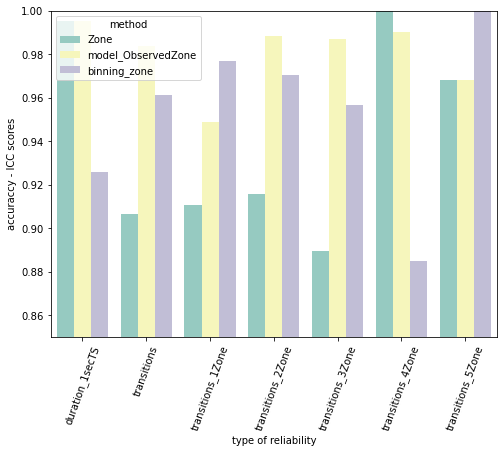

In [33]:
li_rel_type = ['duration_1secTS', 'transitions','transitions_1Zone', 'transitions_2Zone', 'transitions_3Zone',
               'transitions_4Zone', 'transitions_5Zone']
df_plt = df_results[(df_results['nbr_batch']==len(df_testing['BatchID'].unique()))&\
                    (df_results['reliability_type'].isin(li_rel_type))]
print(df_plt.shape)
#df_plt[['runID','method','accuracy_ICC']]
plt.figure(figsize=(8,6))
ax = sns.barplot(x="reliability_type", y="accuracy_ICC", hue="method", data=df_plt, palette="Set3")
plt.xticks(fontsize=10,rotation=70)
plt.ylim(0.85,1)
plt.xlabel('type of reliability')
plt.ylabel('accuraccy - ICC scores')
#plt.savefig(os.path.join(path_extracted_data_cleaning,'ReliabilityMethodsComparison.png'), bbox_inches='tight')

df_results[(df_results['runID']=='65999852-3024-11eb-a16f-9822ef705bb4')&\
           (df_results['reliability_type']=='transitions')] #[['accuracy','ICC','accuracy_ICC']]

df_results = pd.read_csv(os.path.join(path_extracted_data_cleaning,'reliability_RESULTS.csv'), sep=';')
print(df_results.shape)
df_results.head(3)